# 中心性算出の比較
通常のネットワークに対して中心性算出をした場合とVGAEによって生成されたネットワークの中心性算出した場合を比較する

In [1]:
# GPU&PyTorchの動作確認
import os
import sys
import torch

print("Python：" + sys.version)
print("PyTorch：" + torch.__version__)

if torch.cuda.is_available():
    print("CUDA：" + torch.version.cuda)
    print("GPU：" + torch.cuda.get_device_name(0))
else:
    print("GPU is not available.")


Python：3.12.11 (main, Aug 19 2025, 12:03:11) [GCC 11.4.0]
PyTorch：2.8.0+cu128
CUDA：12.8
GPU：NVIDIA GeForce RTX 3060


## データの取得
### neo4jのグラフデータベースからデータを取得する

In [1]:
from neo4j import GraphDatabase
import pandas as pd

# neo4j serverに接続するdriverの設定
driver = GraphDatabase.driver('neo4j://graph-db:7687')

# 取引データを取得する
def fetch_transaction(tx, contract_address = "all"):
    query = "MATCH p=()-[r:TRANSFER]->() RETURN p"
    if contract_address != "all":
        query = """
        MATCH p=()-[r:TRANSFER]->()
        WHERE r.contractAddress <> $address
        RETURN p
        """

    transactions = tx.run(query, address=contract_address)
    return list(transactions)

# contract_address = "0x76B50696B8EFFCA6Ee6Da7F6471110F334536321"
contract_address = "all"  # 全てのトランザクションを取得する場合は "all" を指定
transactions = list()
relations = list()

# neo4jに接続してトランザクションを実行
with driver.session() as session:
    transactions = session.execute_read(fetch_transaction, contract_address)

# トランザクションの結果をリストに保存
for transaction in transactions:
    path = transaction["p"]
    relationship = path.relationships[0]

    relations.append({
        "tokenId": relationship["tokenId"],
        "from": path.start_node["address"], 
        "to": path.end_node["address"],
        "gasPrice": relationship["gasPrice"],
        "gasUsed": relationship["gasUsed"],
        "contractAddress": relationship["contractAddress"],
        "tokenUri": relationship["tokenUri"],
        "blockNumber": relationship["blockNumber"],
    })

# 結果をpandasで保存
df_relation = pd.DataFrame(relations)
df_relation.to_csv("/trust-engine/2025/cirp_data/transactions.csv", index=True)
df_train = df_relation[df_relation['contractAddress'] != "0x76B50696B8EFFCA6Ee6Da7F6471110F334536321"]
df_val = df_relation[df_relation['contractAddress'] == "0x76B50696B8EFFCA6Ee6Da7F6471110F334536321"]
display(df_relation.head())
print(f"Total transactions fetched: {len(df_relation)}, Training transactions: {len(df_train)}, Validation transactions: {len(df_val)}")

,tokenId,from,to,gasPrice,gasUsed,contractAddress,tokenUri,blockNumber
0,569,0xb8a150AcfC753C81e5581D07Bb2eAf6589D5f5D7,0xcfF520E164A5F12F07DD01C2a3Da078baD389DFA,0.664817,0.000249,0x9Ef31ce8cca614E7aFf3c1b883740E8d2728Fe91,https://cryptofish.us/metadata/569.json,22670472
1,566,0xdc3F4b133561ab3278CF50740b9b6AC6cAb34fF1,0x824bCEDc77A27C3D8d45573FF14A10BD4B215403,0.601496,0.000129,0x9Ef31ce8cca614E7aFf3c1b883740E8d2728Fe91,https://cryptofish.us/metadata/566.json,22843294
2,452,0xD6Dab4691EE54FD06b3E834c90b78ff5cb633ee8,0xCd2Bf86463272A3572c3d6ddDD70E06d83dCe3d2,2.569175,0.000249,0x9Ef31ce8cca614E7aFf3c1b883740E8d2728Fe91,https://cryptofish.us/metadata/452.json,22906664
3,550,0xdc3F4b133561ab3278CF50740b9b6AC6cAb34fF1,0x95894a9dA8596206545787300f2e77c5B68E5aC6,2.088123,0.000152,0x9Ef31ce8cca614E7aFf3c1b883740E8d2728Fe91,https://cryptofish.us/metadata/550.json,22992836
4,282,0xe25ACC4ee8311F06bfB688f7363ac6dEF7650D28,0x23FBD8Efe84B35a746b2Fe2a96bcdA2578f57D53,2.088123,0.000152,0x9Ef31ce8cca614E7aFf3c1b883740E8d2728Fe91,https://cryptofish.us/metadata/282.json,23048375


Total transactions fetched: 48666, Training transactions: 48631, Validation transactions: 35


### 学習用のグラフデータの可視化

In [3]:
import networkx as nx
import matplotlib.pyplot as plt
import japanize_matplotlib

train_graph = nx.DiGraph()
for index, transaction in df_train.iterrows():
    train_graph.add_edge(transaction["from"], transaction["to"])
print(f"学習用ネットワーク: ノード数={train_graph.number_of_nodes()}, エッジ数={train_graph.number_of_edges()}")


学習用ネットワーク: ノード数=13713, エッジ数=24901


### 中心性による頂点特徴量を求める
- NFT取引においてユーザーの頂点特徴量は利用できない
- 中心性を用いてネットワークの構造を捉える

In [4]:
df_train_feature = pd.DataFrame(
    index=list(train_graph.nodes),
    columns=["degree", "betweenness", "pagerank"]
)

# 次数中心性
degree = nx.in_degree_centrality(train_graph)
df_train_feature["degree"] = pd.Series(degree)
# 媒介中心性
betweenness = nx.betweenness_centrality(train_graph)
df_train_feature["betweenness"] = pd.Series(betweenness)
# PageRank
pagerank = nx.pagerank(train_graph, max_iter=1000)
df_train_feature["pagerank"] = pd.Series(pagerank)

# ガス代を集計して特徴量に追加
df_train_feature = df_train_feature.merge(
    df_train.groupby('from')[['gasPrice', "gasUsed"]].sum().add(
        df_train.groupby('to')[['gasPrice', "gasUsed"]].sum(),
        fill_value=0
    ),
    left_index=True,
    right_index=True,
    how='left'
)

# ブロック番号を追加
df_train_feature = df_train_feature.merge(
    df_train.groupby('from')[['blockNumber']].first().add(
        df_train.groupby('to')[['blockNumber']].first(),
        fill_value=0
    ),
    left_index=True,
    right_index=True,
    how='left'
)

display(df_train_feature.head())

,degree,betweenness,pagerank,gasPrice,gasUsed,blockNumber
0xb8a150AcfC753C81e5581D07Bb2eAf6589D5f5D7,0.000000,0.000000,0.000023,0.664817,0.000249,22670472.0
0xcfF520E164A5F12F07DD01C2a3Da078baD389DFA,0.000073,0.000041,0.000042,2.752939,0.000401,45763136.0
0xdc3F4b133561ab3278CF50740b9b6AC6cAb34fF1,0.000219,0.000333,0.000059,8.953987,0.000736,45935187.0
0x824bCEDc77A27C3D8d45573FF14A10BD4B215403,0.000073,0.000000,0.000048,0.601496,0.000129,22843294.0
0xD6Dab4691EE54FD06b3E834c90b78ff5cb633ee8,0.000292,0.000364,0.000089,13.180728,0.001084,46006362.0


### データ構造をNetworkXからPyTorch Dataに変換する

In [5]:
from torch_geometric.data import Data

# ノードのユニークIDを取得し、ノードのインデックスを辞書として作成
unique_nodes = pd.concat([df_train['from'], df_train['to']]).unique()
node_to_index = {node: idx for idx, node in enumerate(unique_nodes)}

# pytorch_geometricに変換
edge_index = torch.tensor(
    [[node_to_index[row['from']], node_to_index[row['to']]] for _, row in df_train.iterrows()],
    dtype=torch.long
).t().contiguous()

# ノードの特徴量をdf_train_featureから取得
x = torch.tensor(df_train_feature.loc[unique_nodes].values, dtype=torch.float)
data = Data(x=x, edge_index=edge_index)
print(f"Node num: {data.x.shape[0]}, Node size: {data.x.shape[1]}")

/app/.venv/lib/python3.12/site-packages/torch_geometric/typing.py:68: UserWarning: An issue occurred while importing 'pyg-lib'. Disabling its usage. Stacktrace: /app/.venv/lib/python3.12/site-packages/libpyg.so: undefined symbol: _ZN2at4_ops11multinomial4callERKNS_6TensorElbSt8optionalINS_9GeneratorEE
  warnings.warn(f"An issue occurred while importing 'pyg-lib'. "
/app/.venv/lib/python3.12/site-packages/torch_geometric/typing.py:124: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: /app/.venv/lib/python3.12/site-packages/torch_sparse/_hgt_sample_cuda.so: undefined symbol: _ZN2at4_ops11multinomial4callERKNS_6TensorElbSt8optionalINS_9GeneratorEE
  warnings.warn(f"An issue occurred while importing 'torch-sparse'. "


Node num: 13713, Node size: 6
Edge From: tensor([    0,     1,     2,  ..., 10642, 10652, 10652])
Edge To: tensor([  112, 10671,  6965,  ..., 10642, 10647, 10647])


## VGAEの実装

### モデルの定義

In [7]:
import torch
from torch_geometric.nn import GCNConv, VGAE

# VGAE
class GraphEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GraphEncoder, self).__init__()
        self.conv1 = GCNConv(in_channels, 2 * out_channels)
        self.conv_mu = GCNConv(2 * out_channels, out_channels)
        self.conv_logstd = GCNConv(2 * out_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return self.conv_mu(x, edge_index), self.conv_logstd(x, edge_index)

In [8]:
in_channels = data.x.size(-1)
out_channels = 3
model = VGAE(GraphEncoder(in_channels=in_channels, out_channels=out_channels))
print(f"入力特徴量の次元: {in_channels}, 出力特徴量の次元: {out_channels}")

入力特徴量の次元: 6, 出力特徴量の次元: 3


## モデルの学習
- 学習回数: 300回
- パラメータの更新: Adam

In [15]:
# 学習パラメータの設定
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
train_data = data.to(device)
epoch_num = 300
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
best_loss = float('inf')

# 学習
for epoch in range(1, epoch_num + 1):
    model.train()
    optimizer.zero_grad()
    z = model.encode(train_data.x, train_data.edge_index)
    recon_loss = model.recon_loss(z, train_data.edge_index)
    kl_loss = (1 / train_data.num_nodes) * model.kl_loss()
    loss = recon_loss + kl_loss
    loss.backward()
    optimizer.step()

    # ベストモデルの保存
    if loss < best_loss:
        best_loss = loss
        # モデルの保存
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
        }, os.path.join('/trust-engine/2025/cirp_data', 'best_model.pt'))

    if epoch % 50 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')

Epoch 50, Loss: 49580788.0
Epoch 100, Loss: 8880766.0
Epoch 150, Loss: 2653422.0
Epoch 200, Loss: 828108.5625
Epoch 250, Loss: 263383.96875
Epoch 300, Loss: 102598.609375


## VGAEの検証
- 一つのコミュニティのみの取引ネットワークのみで検証する
- GCNでリンク予測した場合とVGAEでネットワーク生成した場合を比較する

In [16]:
# グラフデータに変換
val_graph = nx.DiGraph()
for index, transaction in df_val.iterrows():
    val_graph.add_edge(transaction["from"], transaction["to"])
print(f"評価用グラフ: ノード数={val_graph.number_of_nodes()}, エッジ数={val_graph.number_of_edges()}")

# 評価用グラフの特徴量を計算
df_val_feature = pd.DataFrame(
    index=list(val_graph.nodes),
    columns=["degree", "betweenness", "pagerank"]
)

# 中心性を算出
degree = nx.in_degree_centrality(val_graph)
df_val_feature["degree"] = pd.Series(degree)
betweenness = nx.betweenness_centrality(val_graph)
df_val_feature["betweenness"] = pd.Series(betweenness)
pagerank = nx.pagerank(val_graph, max_iter=1000)
df_val_feature["pagerank"] = pd.Series(pagerank)

# ガス代を集計して特徴量に追加
df_val_feature = df_val_feature.merge(
    df_val.groupby('from')[['gasPrice', "gasUsed"]].sum().add(
        df_val.groupby('to')[['gasPrice', "gasUsed"]].sum(),
        fill_value=0
    ),
    left_index=True,
    right_index=True,
    how='left'
)

# ブロック番号を追加
df_val_feature = df_val_feature.merge(
    df_val.groupby('from')[['blockNumber']].first().add(
        df_val.groupby('to')[['blockNumber']].first(),
        fill_value=0
    ),
    left_index=True,
    right_index=True,
    how='left'
)

# pytorchのテンソルに変換する
unique_nodes = pd.concat([df_val['from'], df_val['to']]).unique()
node_to_index = {node: idx for idx, node in enumerate(unique_nodes)}
edge_index = torch.tensor(
    [[node_to_index[row['from']], node_to_index[row['to']]] for _, row in df_val.iterrows()],
    dtype=torch.long
).t().contiguous()
x = torch.tensor(df_val_feature.loc[unique_nodes].values, dtype=torch.float)
data = Data(x=x, edge_index=edge_index)
val_data = data.to(device)

評価用グラフ: ノード数=50, エッジ数=29


### VGAEにおけるネットワーク生成

In [17]:
model.eval()
with torch.no_grad():
    z = model.encode(val_data.x, val_data.edge_index)  # エンコーダを使用して潜在ベクトルzを生成

    # 潜在ベクトルzをデコードして隣接行列を生成
    adj = z @ z.t()  # xとzの内積を計算して隣接行列を生成
    adj = torch.sigmoid(adj)  # Sigmoid関数を適用して隣接行列を確率に変換
    tau = 0.5
    adj_matrix = (adj > tau).nonzero(as_tuple=False).t()
    sample = adj_matrix[:, torch.randperm(adj_matrix.size(1))[:data.num_edges]]  # エッジをサンプリング

生成されたグラフ: ノード数=50, エッジ数=35


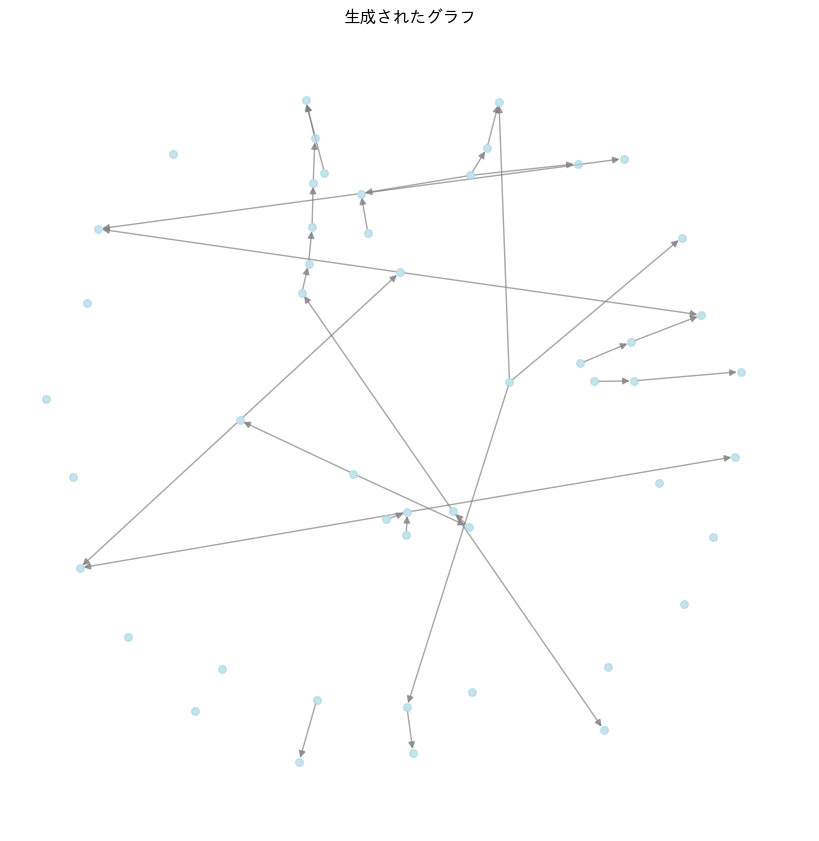

In [18]:
gen_graph = nx.DiGraph()  # 有向グラフの作成
gen_graph.add_nodes_from(range(val_data.num_nodes))  # ノードを追加
gen_graph.add_edges_from(sample.t().cpu().numpy())  # エッジを追加
print(f"生成されたグラフ: ノード数={gen_graph.number_of_nodes()}, エッジ数={gen_graph.number_of_edges()}")

plt.figure(figsize=(8, 8))
nx.draw(gen_graph, with_labels=False, node_size=30, node_color='lightblue', edge_color='gray', alpha=0.7)
plt.title("生成されたグラフ")
plt.show()

In [77]:
import seaborn as sns

# gen_graphの中心性を計算
degree_centrality = nx.degree_centrality(gen_graph)
betweenness_centrality = nx.betweenness_centrality(gen_graph)
pagerank_centrality = nx.pagerank(gen_graph)

# gen_graphの中心性をDataFrameに変換
df_gen_centrality = pd.DataFrame({
    'degree': list(degree_centrality.values()),
    'betweenness': list(betweenness_centrality.values()),
    'pagerank': list(pagerank_centrality.values()),
    'type': 'generate'
})

# df_val_featureから必要な列を抽出してtypeを追加
df_val_centrality = df_val_feature[['degree', 'betweenness', 'pagerank']].copy()
df_val_centrality['type'] = 'val'

# 中心性のDataFrameを結合
df_centrality = pd.concat([df_gen_centrality, df_val_centrality], ignore_index=True)
w = pd.melt(df_centrality, id_vars=["type"])
display(w.head())

# 中心性のDataFrameを結合
df_centrality = pd.concat([df_gen_centrality, df_val_centrality], ignore_index=True)
w = pd.melt(df_centrality, id_vars=["type"])

,type,variable,value
0,generate,degree,0.000000
1,generate,degree,0.020408
2,generate,degree,0.020408
3,generate,degree,0.040816
4,generate,degree,0.020408


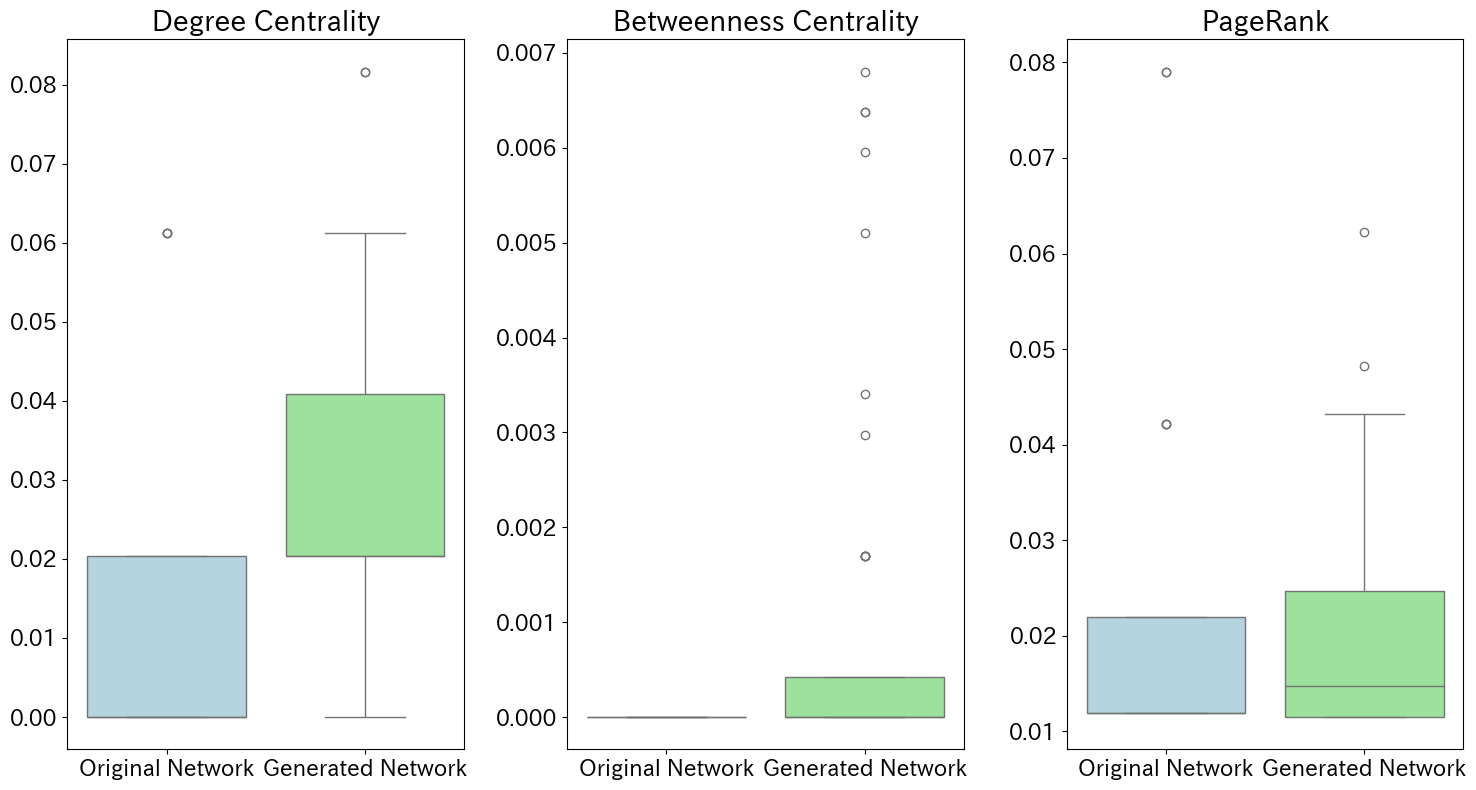

In [89]:
# サブプロットで各中心性を別々に表示
fig, axes = plt.subplots(1, 3, figsize=(15, 8))

# 各中心性指標ごとにプロット
centrality_types = ['degree', 'betweenness', 'pagerank']
x_order = ['val', 'generate']

for i, centrality in enumerate(centrality_types):
    # 該当する中心性のデータのみを抽出
    data_subset = w[w['variable'] == centrality]
    
    # 箱ひげ図を描画
    sns.boxplot(
        x='type', 
        y='value', 
        data=data_subset, 
        ax=axes[i], 
        order=x_order,
        hue='type',
        palette={"val": "lightblue", "generate": "lightgreen"}
    )

    # タイトルとラベルの設定
    if centrality == 'degree' or centrality == 'betweenness':
        axes[i].set_title(f'{centrality.capitalize()} Centrality', fontsize=20)
    else:
        axes[i].set_title(f'PageRank', fontsize=20)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('', fontsize=16)
    axes[i].tick_params(axis='y', labelsize=16)
    axes[i].set_xticks([0, 1])
    axes[i].set_xticklabels(["Original Network", "Generated Network"], fontsize=16)

plt.tight_layout()
plt.savefig("/trust-engine/2025/cirp_data/centrality_boxplots.png")
plt.show()